In [ ]:
# Install FEniCS
try:
  import google.colab  # noqa: F401
except ImportError:
  import ufl
  import dolfin
else:
  try:
    import ufl
    import dolfin
  except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import ufl
    import dolfin

--2022-04-25 08:53:45--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-04-25 08:53:45 (24.7 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

# Reminder of previous homework:

Consider 2D heat transfer across the domain shown in the figure below. Solve the heat transfer problem, with the following boundary conditions:

• The $AB$, $CD$, $EF$, and $GH$ boundaries are insulated. (Neumann boundary condition with the heat flux g = 0 W/m.)

• The $BC$, $DE$, $FG$, and $HA$ boundaries are convecting to 25°C with a heat transfer coefficient of 750 W/(m$^2$°C).

• The internal part of the boundary is convecting is convecting to 100°C with a heat transfer coefficient of 750 W/(m$^2$°C).

In the domain use the following material property:

• The thermal conductivity is 52 W/(m·°C).


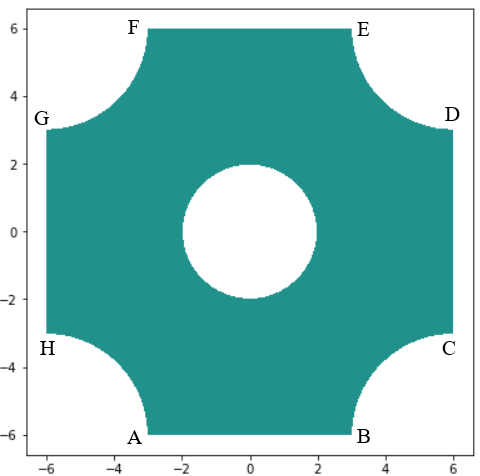

dim(Vh) =  17323


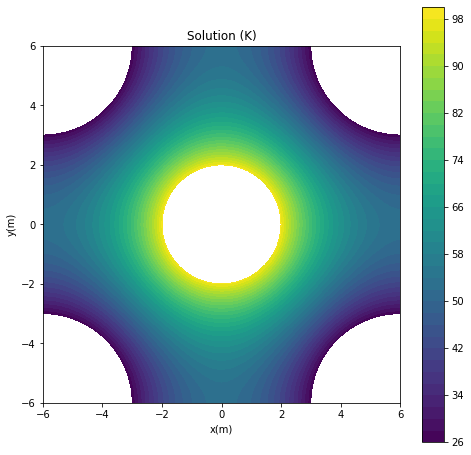

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt
from mshr import *
#
# to plot the result in the Notebook
%matplotlib inline
#
d = 1
#
domain = Rectangle(Point( -6.0, -6.0 ),Point ( 6.0, 6.0 ) )- Circle(Point(6,6),3) - Circle(Point(-6,6),3) - Circle(Point(-6,-6),3)\
 - Circle(Point(6,-6),3) - Circle(Point(0,0), 2)
mesh = generate_mesh (domain ,50)
Vh  = FunctionSpace(mesh, 'P', 2)
print ("dim(Vh) = ", Vh.dim())

g  = Constant(0.)
h  = Constant(750.0)
T0 = Constant(25.0) # for external shape
T1 = Constant(100.0) # for hole
kappa = Constant(52.)
f = Expression('(x[0] * x[0]) + (x[1] * x[1])', degree=d+2)
#
# Define boundary labels
#
class LeftBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0] , -6) and between(x[1] , (-3,3))

class RightBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0] - 6.0, 0) and between(x[1] , (-3,3))

class BottomBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1] , -6.0) and between(x[0] , (-3,3))

class TopBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1], 6.0) and between(x[0] , (-3,3))
#
class Inner_Cercle(SubDomain):
  def inside(self , x , on_boundary):
      r = sqrt((x[0])**2 + (x[1])**2)
      return (on_boundary) and (r < 2 * 1.0001)

class Top_Right_hole(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt((x[0] -6)**2 + (x[1] - 6)**2)
        return (on_boundary) and (r < 3 * 1.0001)

class Top_Left_hole(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt((x[0] +6)**2 + (x[1] - 6)**2)
        return (on_boundary) and (r < 3 * 1.0001)

class Bottom_left_hole(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt((x[0] +6 )**2 + (x[1] + 6)**2)
        return (on_boundary) and (r < 3 * 1.0001)

class Bottom_Right_hole(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt((x[0] - 6)**2 + (x[1] + 6)**2)
        return (on_boundary) and (r < 3 * 1.0001)

leftBoundary = LeftBoundary()
rightBoundary = RightBoundary()
topBoundary = TopBoundary()
bottomBoundary = BottomBoundary()
top_right_hole = Top_Right_hole()
top_Left_hole = Top_Left_hole()
bottom_left_hole = Bottom_left_hole()
bottom_right_hole = Bottom_Right_hole()
inner_Cercle = Inner_Cercle()

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
#
# mark the entire boundary as 0
#
boundaries.set_all(0)
#
# Mark the isolated parts of the boundaries as subdomains  1
#
rightBoundary.mark(boundaries, 1)
leftBoundary.mark(boundaries, 1)
topBoundary.mark(boundaries, 1)
bottomBoundary.mark(boundaries, 1)
#
# Mark the convective parts of the boundaries as subdomains  2 and 3
#
top_right_hole.mark(boundaries, 2)
top_Left_hole.mark(boundaries, 2)
bottom_right_hole.mark(boundaries, 2)
bottom_left_hole.mark(boundaries, 2)
inner_Cercle.mark(boundaries, 3)
#
#  ds: surface integration
#
ds=Measure('ds', domain=mesh, subdomain_data=boundaries)
#
#  weak form
u = TrialFunction(Vh)
v = TestFunction(Vh)
#
a = kappa*dot(grad(u), grad(v))*dx + h*u*v*ds(2) + h*u*v*ds(3)
L =  f*v*dx + g*v*ds(1) + h*T0*v*ds(2) + h*T1*v*ds(3)
#
uh = Function(Vh)
#
# Solution
solve(a==L, uh)
#
plt.figure(figsize=(8,8))
p = plot(uh)
plt.title('Solution (K)')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.colorbar(p)

# The new homework:

Consider 2D heat transfer across the domain shown in the figure below. Solve the heat transfer problem, with the following boundary conditions:

• The upper boundary is kept at 50°C. (Dirichlet boundary condition).

• The lower boundary is insulated. (Neumann boundary condition with the heat flux g = 0 W/m.)

• At the left boundary, Neumann boundary condition is considered with the heat flux g = -100 W/m.

• The right boundary is convecting to 20°C with a heat transfer coefficient of 2 W/(m$^2$°C).

In the domain use the following material property:

• The thermal conductivity is 0.935 W/(m·°C).



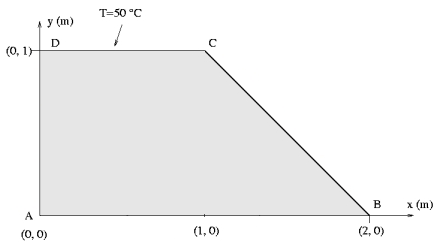


Calling FFC just-in-time (JIT) compiler, this may take some time.


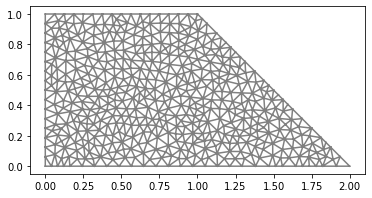

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt
from mshr import *
# to plot the result in the Notebook
%matplotlib inline
# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),
                   Point(2.0, 0.0),
                   Point(1.0, 1.0),
                   Point(0.0, 1.0),
                   Point(0.0, 0.0)]
#
# Generate mesh and plot
domain = Polygon(domain_vertices)
#
mesh = generate_mesh(domain,20)


plot(mesh)

Vh  = FunctionSpace(mesh, 'Lagrange', 2)

In [ ]:
k = Constant(0.935)
T0 = Constant(20.)
h = Constant(2.)
u_f = Constant(50.)

g_b = Constant(-100.)
g_0    = Constant(0.)

f = Constant(0.)

In [ ]:
#
# Left boundary:  (x = 0 )
#
class left(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < DOLFIN_EPS
#
# Right boundary:   x + y - 2 = 0
#
class right(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1]+x[0]-2.0, 0.0)
#
# Bottom boundary:  (y = 0 )
#
class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]) < DOLFIN_EPS
#
#  Define Dirichlet boundary condition
#
# Top boundary: ( y = 1)
#
def top(x, on_boundary):
    return (x[1] > 1 - DOLFIN_EPS and on_boundary)
#
bc = DirichletBC(Vh, u_f, top)
#
# Define boundary labels
#
boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
#
# Mark the entire boundary as 0
#
boundary_parts.set_all(0)
#
# Mark the convective parts of the boundaries as subdomains  2, 3 and 4
#
Bottom_p = bottom()
Bottom_p.mark(boundary_parts, 2)
#
Left_p = left()
Left_p.mark(boundary_parts, 3)
#
Right_p = right()
Right_p.mark(boundary_parts, 4)
#
#  ds: surface integration
#
ds = Measure("ds", domain=mesh, subdomain_data=boundary_parts)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


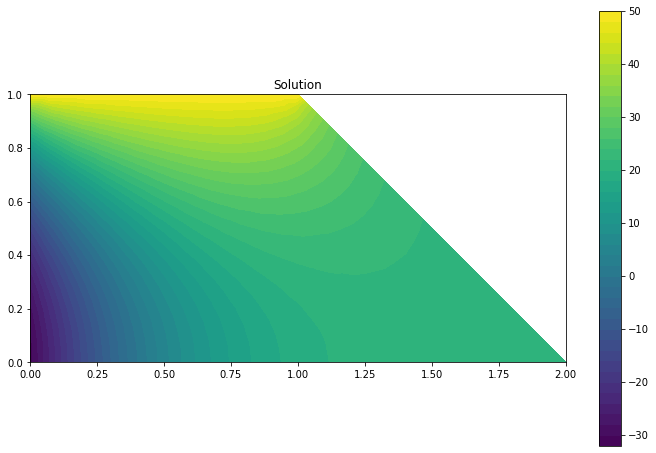

In [ ]:
u = TrialFunction(Vh)
v = TestFunction(Vh)
a = k*inner(nabla_grad(u), nabla_grad(v))*dx + h*u*v*ds(4)
b = f*v*dx + g_0*v*ds(2) + g_b*v*ds(3) + h*T0*v*ds(4)
#
uh = Function(Vh)
solve(a == b, uh, bc)
#
# Plot solution
#
plt.figure(figsize=(12,8))
c = plot(uh, title="Solution")
plt.colorbar(c)